# Hands-on clustering #2:
## Ensemble clustering

### Imports and formatting

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.special import binom

from sklearn.cluster import KMeans, AgglomerativeClustering, MiniBatchKMeans
from sklearn import datasets
from sklearn.metrics import normalized_mutual_info_score

import h5py

plt.style.use('seaborn')
plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 18,
                     'ytick.labelsize' : 18,
                     'legend.fontsize': 20,
                     'axes.labelsize': 20,
                     'axes.titlesize': 20,
                     'figure.figsize': (8, 8)
                    })

## 2. Understanding ensemble methods

#### Binomial distribution functions

In [2]:
def P_k_np(k, n, p):
    return binom(n, k) * p**k * (1-p)**(n-k)

def P_supk_np(k, n, p):
    P = 0
    for i in range(k, n+1):
        P += P_k_np(i, n, p)
    return P

### 2.1 Probability of correct classification when ensembling 1001 models with an accuracy of 51%

In [3]:
p = 0.51
n = 1001

# If k models predict the correct answer, the ensemble is correct when k > n/2 
k_min = int(n/2) + 1

print("Probability of correct prediction: ", P_supk_np(k_min, n, p))

Probability of correct prediction:  0.7366309083614334


### 2.2 With 1001 models, what accuracy is needed on the weak models to outperform the expert model?

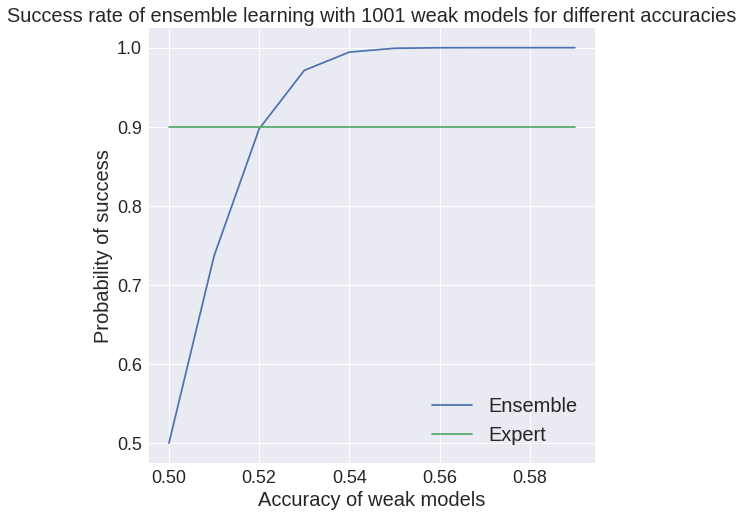

In [4]:
n = 1001
k_min = int(n/2) + 1

P_ensemble = []
x_plot = np.arange(0.50, 0.60, 0.01)
for p in x_plot:
    P_ensemble.append(P_supk_np(k_min, n, p))
    
P_expert = [0.9 for _ in x_plot]
plt.plot(x_plot, P_ensemble)
plt.plot(x_plot, P_expert)
plt.legend(["Ensemble", "Expert"])
plt.xlabel("Accuracy of weak models")
plt.ylabel("Probability of success")
plt.title("Success rate of ensemble learning with 1001 weak models for different accuracies")
plt.show()

#### Comment
With 1001 weak models, each with an accuracy of 0.52, ensemble performance is 0.9 (equal to expert here).

Hence, with an accuracy > 0.52, the ensemble outperforms the expert.

### 3.3 To work as expected, three conditions must be verified by the set o weak learners

#### 1. The number of weak learners must be "large"

The following example presents the ensemble accuracy for different number of weak learners when the individual accuracy is 0.53

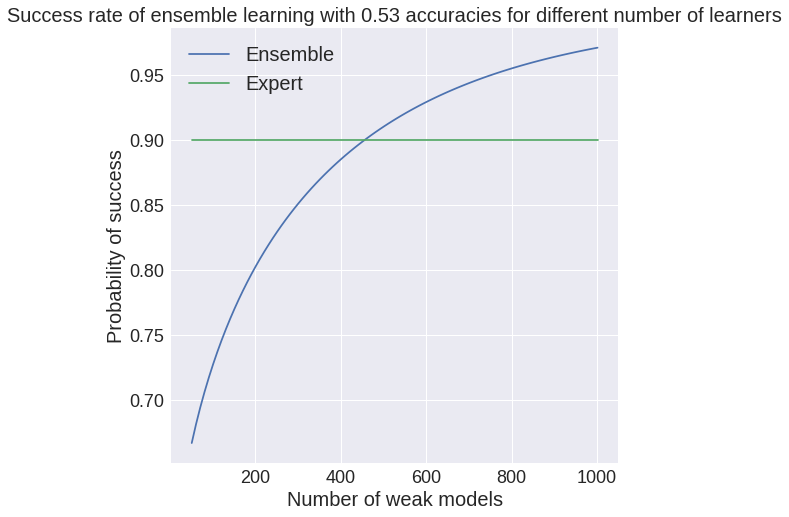

In [6]:
p = 0.53

P_ensemble = []
x_plot = np.arange(51, 1011, 10)
for n in x_plot:
    k_min = int(n/2) + 1
    P_ensemble.append(P_supk_np(k_min, n, p))
    
P_expert = [0.9 for _ in x_plot]
plt.plot(x_plot, P_ensemble)
plt.plot(x_plot, P_expert)
plt.legend(["Ensemble", "Expert"])
plt.xlabel("Number of weak models")
plt.ylabel("Probability of success")
plt.title("Success rate of ensemble learning with 0.53 accuracies for different number of learners")
plt.show()

#### 2. The individual learners must be "good"

Individual models in ensembles must be at least better than random classification.

The following example illustrates the behavior of ensemble when individual models have an accuracy of 0.47

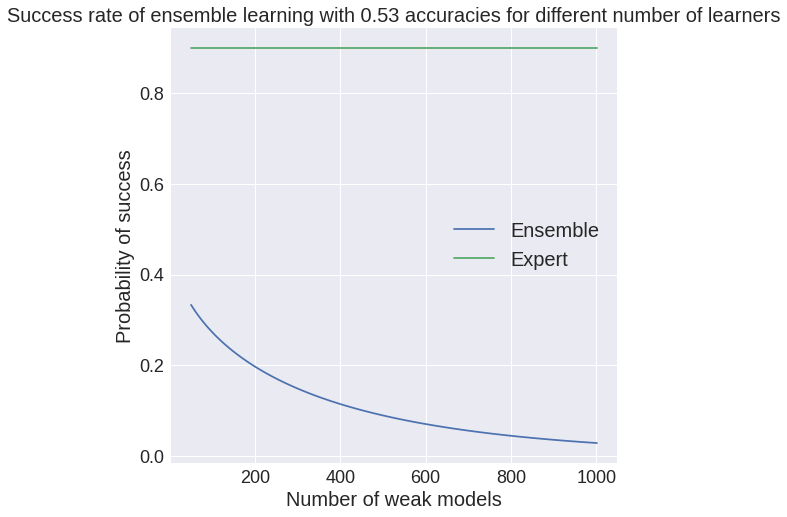

In [302]:
p = 0.47

P_ensemble = []
x_plot = np.arange(51, 1011, 10)
for n in x_plot:
    P_ensemble.append(P_supk_np(int(n/2) + 1, n, p))
    
P_expert = [0.9 for _ in x_plot]
plt.plot(x_plot, P_ensemble)
plt.plot(x_plot, P_expert)
plt.legend(["Ensemble", "Expert"])
plt.xlabel("Number of weak models")
plt.ylabel("Probability of success")
plt.title("Success rate of ensemble learning with 0.53 accuracies for different number of learners")
plt.show()

Obviously, there is a strong relation between how good the individual learners are and the number of weak models that is needed for good performance. For example, if weak models have an accuracy of 0.7, 13 models are sufficient to generate strong ensemble predictions (> 0.9).

In [9]:
p = 0.7
n = 13
k_min = int(n/2) + 1

print("Probability of correct prediction: ", P_supk_np(k_min, n, p))

Probability of correct prediction:  0.9376247882008


#### 3. Weak learners must be diverse: 

If all weak model predict the same thing, i.e., make the same mistakes, then the ensemble is not better than the individual weak models. 

_Note: All the computations above assume that all weak models are independent, which is rarely true in practice_

## 3. Ensemble methods for clustering

### 3.1 Generating clustering partitions

#### List of possible ways to generate clustering partitions

1. Use different clustering algorithms
    1. Different approaches
    2. Different parameters
2. Use different features
    1. Subsets of the features
    2. Different modeling of the problem
    3. Different data transformation
3. Use different initializations
4. Use different subsets of data


#### Generate data

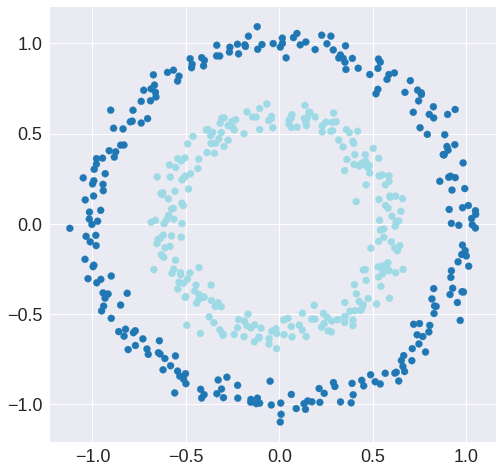

In [10]:
n_samples = 500
noisy_circles, labels_noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.6, noise=0.05)

plt.scatter(noisy_circles[:, 0], noisy_circles[:, 1], c=labels_noisy_circles, cmap="tab20")
plt.show()

#### 3.1.1 Run regular Kmeans

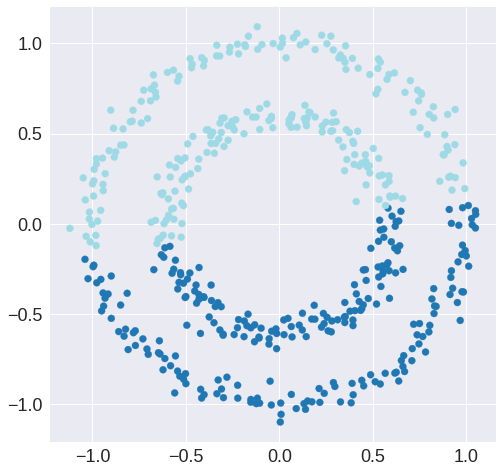

NMI:  4.6170754553780054e-05


In [13]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(noisy_circles)

plt.scatter(noisy_circles[:, 0], noisy_circles[:, 1], c=clusters, cmap="tab20")
plt.show()

print("NMI: ", normalized_mutual_info_score(labels_noisy_circles, clusters))

#### Comments:

Kmeans clearly did not work for these data.

#### 3.1.2 Generating 100 partitions using Kmeans with 100 clusters

In [15]:
kmeans = KMeans(n_clusters=100)

clusters = []
for _ in range(100):
    clusters.append(kmeans.fit_predict(noisy_circles))
clusters = np.array(clusters)

Let's now display 3 of these cluster assignments.

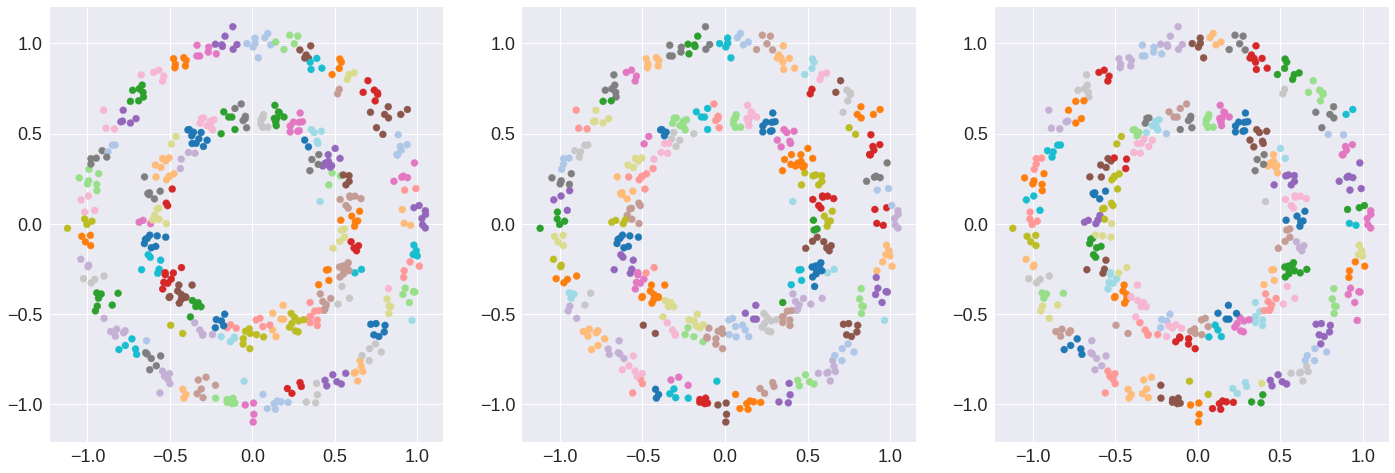

In [21]:
plt.figure(figsize=(24, 8))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(noisy_circles[:, 0], noisy_circles[:, 1], c=clusters[i], cmap="tab20")
plt.show()

#### Comments

- Clusters are definitely "good" (better than random)
- There is "a high number" of partitions (> 100)
- Regarding diversity, all three clustering partitions shown above are slightly different but most points appear to share common clustering within the three partitions.

### 3.2 Consensus function

- The grouping strategy presented in Section 2 (simple majority voting) is used for supervised classification problems. For clustering, it cannot be used straightforwardly because of the label correspondance problem.
- The most straightforward approach to consensus would be relabelling and voting. Other approaches exist, here we will see one based on counting co-occurrence of points in clusters between different partitions.

#### 3.2.1 Co-Association Matrix function

In [22]:
def compute_CoAssociationMatrix(clusters):
    n_samples = clusters.shape[1]
    CAM = np.zeros((n_samples, n_samples))
    for i in range(clusters.shape[0]):
        for j in range(n_samples):
            for k in range(j+1, n_samples):
                if clusters[i][j] == clusters[i][k]:
                    CAM[j, k] += 1
                    CAM[k, j] += 1
    return CAM

#### 3.2.2 Cluster the Co-Association Matrix

- Agglomerative clustering can be used to cluster a dataset based on precomputed distances
- The Co-Association Matrix represents the similarity between two points in dataset. As Agglomerative Clustering requires distances (dissimilarities) we need to pass the opposite of the Co-Association Matrix as argument.

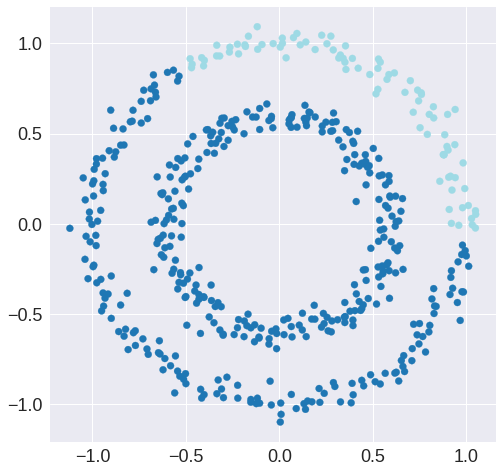

In [23]:
CoAssociationMatrix = compute_CoAssociationMatrix(clusters)

agg = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="average")
clusters = agg.fit_predict(-CoAssociationMatrix)

plt.scatter(noisy_circles[:, 0], noisy_circles[:, 1], c=clusters, cmap="tab20")
plt.show()

#### 3.2.3 Initialization issue

- The algorithm did not work as expected
- Previously, we noted that the diversity in the partitions was limited, this is due to the default parameters of Kmeans. Indeed, by default, Scikit-learn Kmeans runs the "Kmeans++" algorithm to properly initialize parameters and conducts multiple initializations (10). This has the effect of limiting the diversity in the partitions because each run converges to a similar local minimum.
- To correct this issue we need to set Kmeans initialization to random and the number of restart to 1. this will "reduce the performance" of the individual partitions, but increase the diversity.

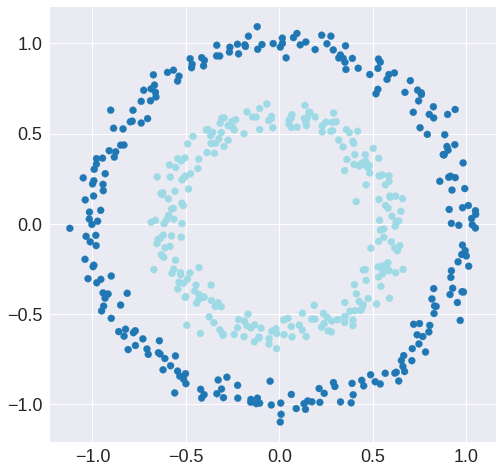

In [24]:
kmeans = KMeans(n_clusters=100, init="random", n_init=1)

clusters = []
for _ in range(100):
    clusters.append(kmeans.fit_predict(noisy_circles))
clusters = np.array(clusters)

CoAssociationMatrix = compute_CoAssociationMatrix(clusters)

agg = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="average")
clusters = agg.fit_predict(-CoAssociationMatrix)

plt.scatter(noisy_circles[:, 0], noisy_circles[:, 1], c=clusters, cmap="tab20")
plt.show()

#### 3.2.4 Find the good number of clusters in each partitions for 100 partitions

In [26]:
nmis = []
for k in range(8, 26, 2):
    kmeans = KMeans(n_clusters=k, init="random", n_init=1)

    clusters = []
    for _ in range(100):
        clusters.append(kmeans.fit_predict(noisy_circles))
    clusters = np.array(clusters)

    CoAssociationMatrix = compute_CoAssociationMatrix(clusters)

    agg = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="average")
    clusters = agg.fit_predict(-CoAssociationMatrix)
    
    nmis.append(normalized_mutual_info_score(labels_noisy_circles, clusters))
    
    print(k, "NMI: ", nmis[-1])

8 NMI:  0.00010671031839584173
10 NMI:  1.1614593320607666e-05
12 NMI:  0.0005747124511356716
14 NMI:  0.002344699033873598
16 NMI:  0.0019517867335456106
18 NMI:  0.0011580963464599236
20 NMI:  1.0
22 NMI:  1.0
24 NMI:  1.0


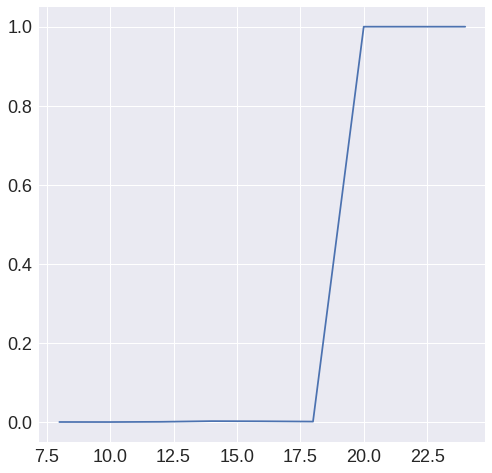

In [27]:
plt.plot(range(8, 26, 2), nmis)

#### Comments:
Ensemble of 100 partitions containing 20 clusters appear to work well for the concentric circle data.

### 3.3 Repeat the process for the elongated blob data

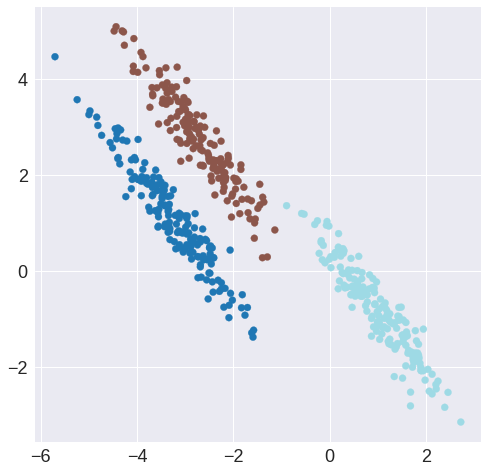

In [32]:
random_state = 170
X, labels_blobs = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
blobs = np.dot(X, transformation)

plt.scatter(blobs[:, 0], blobs[:, 1], c=labels_blobs, cmap="tab20")

In [37]:
kmeans = KMeans(n_clusters=20, init="random", n_init=1)

clusters = []
for _ in range(100):
    clusters.append(kmeans.fit_predict(blobs))
clusters = np.array(clusters)

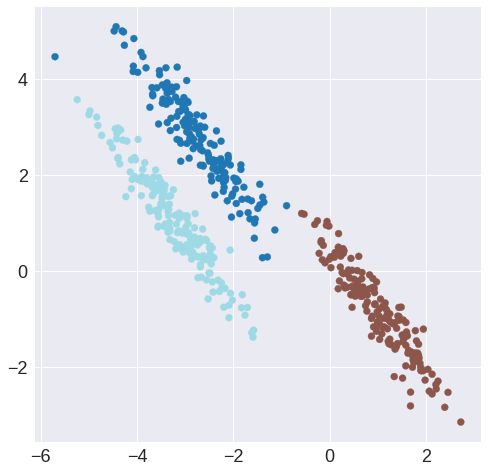

In [38]:
CoAssociationMatrix = compute_CoAssociationMatrix(clusters)

agg = AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="average")
clusters = agg.fit_predict(-CoAssociationMatrix)

plt.scatter(blobs[:, 0], blobs[:, 1], c=clusters, cmap="tab20")
plt.show()

## 4. Practical implementation of Ensemble clustering

- The objective is to group together images representing the same person. The dataset contains 2800 images (200 persons and 14 images per person). As there is 200 persons, the number of expected clusters is 200.

#### 4.1 Running Kmeans on a single representation

In [39]:
filename = "../Data/FEI/representations/densenet121.h5"

f = h5py.File(filename, "r")
data = np.array(f["data"])
labels = np.array(f["labels"])

In [41]:
km = MiniBatchKMeans(200)
clusters = km.fit_predict(data)

print("NMI: ", normalized_mutual_info_score(labels, clusters))

NMI:  0.9046473234792426


#### 4.2 Running Kmeans on all representations

In [42]:
directory = "../Data/FEI/representations/"
files = ["densenet121.h5", "densenet169.h5", "densenet201.h5", "inception.h5", "inception_resnet.h5", "nasnet.h5", 
         "resnet.h5", "vgg16.h5", "vgg19.h5", "xception.h5"]

km = MiniBatchKMeans(200)
clusters = []
for f in files:
    ff = h5py.File(directory + f, "r")
    data = np.array(ff["data"])
    labels = np.array(ff["labels"])
    clusters.append(km.fit_predict(data))
clusters = np.array(clusters)

In [43]:
for i, f in enumerate(files):
    print(f)
    print("        NMI: ", normalized_mutual_info_score(labels, clusters[i]))

densenet121.h5
        NMI:  0.9095134595263429
densenet169.h5
        NMI:  0.8983196622903309
densenet201.h5
        NMI:  0.918532569965124
inception.h5
        NMI:  0.9194262153754665
inception_resnet.h5
        NMI:  0.8695141317368981
nasnet.h5
        NMI:  0.8980176107738275
resnet.h5
        NMI:  0.8965603650996951
vgg16.h5
        NMI:  0.8761822318531438
vgg19.h5
        NMI:  0.8962215673440704
xception.h5
        NMI:  0.8989716408328232


#### Ensemble the results

In [44]:
CoAssociationMatrix = compute_CoAssociationMatrix(clusters)

agg = AgglomerativeClustering(n_clusters=200, affinity="precomputed", linkage="average")
clusters_ensemble = agg.fit_predict(-CoAssociationMatrix)

print("ensemble")
print("        NMI: ", normalized_mutual_info_score(labels, clusters_ensemble))

ensemble
        NMI:  0.9437719946809188


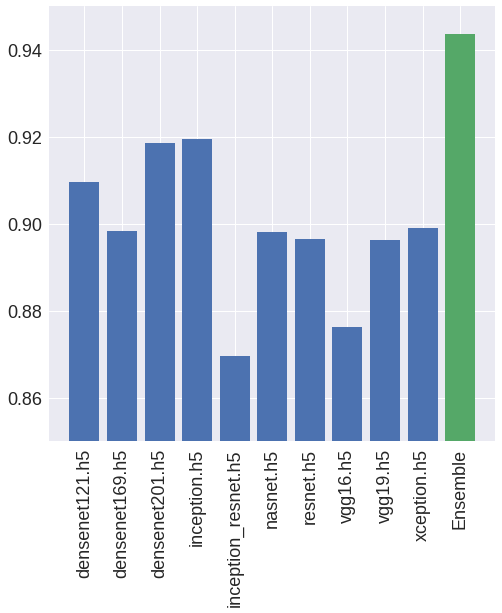

In [65]:
x_bars = [i+1 for i in range(len(clusters))]
y_bars = [normalized_mutual_info_score(labels, c) for c in clusters]

plt.bar(x=x_bars, height=y_bars)
plt.bar(x=[11], height=normalized_mutual_info_score(labels, clusters_ensemble))
plt.ylim([0.85, 0.95])
plt.xticks([i+1 for i in range(11)], labels=files + ["Ensemble"], rotation=90)
plt.show()

## 5. Going further

Here, we propose to test combining

In [68]:
data = datasets.load_iris()
X = data.data
y = data.target

print(X.shape)
print(y.shape, set(y))

(150, 4)
(150,) {0, 1, 2}


In [71]:
from sklearn.cluster import DBSCAN, SpectralClustering, AffinityPropagation, MeanShift
from sklearn.mixture import GaussianMixture

kmeans = KMeans(n_clusters=3)
clusters_km = kmeans.fit_predict(X)
print("NMI kmeans: ", normalized_mutual_info_score(y, clusters_km))

agg = AgglomerativeClustering(n_clusters=3)
clusters_agg = agg.fit_predict(X)
print("NMI agglomerative: ", normalized_mutual_info_score(y, clusters_agg))

spectral = SpectralClustering(n_clusters=3)
clusters_spectral = spectral.fit_predict(X)
print("NMI spectral: ", normalized_mutual_info_score(y, clusters_spectral))

NMI kmeans:  0.7581756800057785
NMI agglomerative:  0.770083661648787
NMI spectral:  0.7979885217013319


In [73]:
clusters = [clusters_km, clusters_agg, clusters_spectral]#, clusters_affinity, clusters_shift, clusters_db, clusters_mixt]
clusters = np.array(clusters)

CoAssociationMatrix = compute_CoAssociationMatrix(clusters)

agg = AgglomerativeClustering(n_clusters=3, affinity="precomputed", linkage="average")
clusters_ensemble = agg.fit_predict(-CoAssociationMatrix)

print("NMI: ", normalized_mutual_info_score(y, clusters_ensemble))

NMI:  0.7979885217013319


#### Comments:
Although ensemble did not allow to reach a better classification, it still allowed to reach a partition corresponding to the best algorithm (here spectral), which was not known a priori.